In [1]:
!pip install catboost
import requests
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
# General libraries
import numpy as np
import pandas as pd
import os
import joblib

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


#machine learning Algorithms For Classification
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.2 MB/s eta 0:00:00


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pavansubhasht/ibm-hr-analytics-attrition-dataset")

print("Path to dataset files:", path)

100%|██████████| 50.1k/50.1k [00:00<00:00, 23.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/versions/1


In [5]:
data = pd.read_csv(os.path.join(path, "WA_Fn-UseC_-HR-Employee-Attrition.csv"))
data.head()  # Print the first few rows

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [6]:
data .info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [7]:
# prompt: display unique values for object columns

for col in data.select_dtypes(include=['object']).columns:
    print(f"Unique values for column '{col}':")
    print(data[col].unique())
    print("-" * 20)



Unique values for column 'Attrition':
['Yes' 'No']
--------------------
Unique values for column 'BusinessTravel':
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
--------------------
Unique values for column 'Department':
['Sales' 'Research & Development' 'Human Resources']
--------------------
Unique values for column 'EducationField':
['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
--------------------
Unique values for column 'Gender':
['Female' 'Male']
--------------------
Unique values for column 'JobRole':
['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
--------------------
Unique values for column 'MaritalStatus':
['Single' 'Married' 'Divorced']
--------------------
Unique values for column 'Over18':
['Y']
--------------------
Unique values for column 'OverTime':
['Yes' 'No']
--------------------


In [8]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()
columns_used_for_One_hot_encode = []
columns_used_for_label_encoder= []

for col in data.columns:
    if data[col].dtype == 'object':
        # Check if the column has more than 2 unique values
        if len(data[col].unique()) > 2:
            # One-hot encode columns with more than two unique values
            data = pd.get_dummies(data, columns=[col], prefix=col)
            columns_used_for_One_hot_encode.append(col)
            joblib.dump(label_encoder, f'One_hot_encode_{col}.joblib')
        else:
            # Label encode binary columns (two unique values)
            data[col] = label_encoder.fit_transform(data[col])
            columns_used_for_label_encoder.append(col)
            joblib.dump(label_encoder, f'label_encoder_{col}.joblib')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                1470 non-null   int64
 1   Attrition                          1470 non-null   int64
 2   DailyRate                          1470 non-null   int64
 3   DistanceFromHome                   1470 non-null   int64
 4   Education                          1470 non-null   int64
 5   EmployeeCount                      1470 non-null   int64
 6   EmployeeNumber                     1470 non-null   int64
 7   EnvironmentSatisfaction            1470 non-null   int64
 8   Gender                             1470 non-null   int64
 9   HourlyRate                         1470 non-null   int64
 10  JobInvolvement                     1470 non-null   int64
 11  JobLevel                           1470 non-null   int64
 12  JobSatisfaction     

In [9]:
data.describe()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,0.161224,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,0.600000,65.891156,...,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,0.367863,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,0.490065,20.329428,...,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,0.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000000,30.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,0.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,0.000000,48.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,0.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,1.000000,66.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,0.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,1.000000,83.750000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,1.000000,100.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [10]:
# Numerical features visualization
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# Categorical features visualization (after encoding)
categorical_features = data.select_dtypes(include=['uint8']).columns  # Assuming one-hot encoded features are uint8
for col in categorical_features:
  plt.figure(figsize=(10, 6))
  sns.countplot(x=data[col])
  plt.title(f'Distribution of {col}')
  plt.xticks(rotation=45, ha='right')
  plt.show()


# Correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Pairplot for selected numerical features (adjust as needed)
selected_numerical_features = ['Age', 'MonthlyIncome', 'TotalWorkingYears', 'YearsAtCompany']
sns.pairplot(data[selected_numerical_features], diag_kind='kde')
plt.show()


# Visualize relationships with target variable (assuming 'Attrition' is your target)
for col in numerical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Attrition', y=col, data=data)
    plt.title(f'{col} vs Attrition')
    plt.show()


for col in categorical_features:
  plt.figure(figsize=(8, 6))
  sns.countplot(x=col, hue='Attrition', data=data)
  plt.title(f'Attrition Rate by {col}')
  plt.xticks(rotation=45, ha='right')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [11]:

# Assuming 'Attrition' is your target variable
X = data.drop('Attrition', axis=1)
y = data['Attrition']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

0:	test: 0.5231775	best: 0.5231775 (0)	total: 6.63ms	remaining: 6.63s
100:	test: 0.7828054	best: 0.7837104 (99)	total: 656ms	remaining: 5.84s
200:	test: 0.7727501	best: 0.7838110 (136)	total: 1.19s	remaining: 4.73s
300:	test: 0.7769734	best: 0.7838110 (136)	total: 1.69s	remaining: 3.92s
400:	test: 0.7753645	best: 0.7838110 (136)	total: 2.42s	remaining: 3.62s
500:	test: 0.7774761	best: 0.7838110 (136)	total: 2.75s	remaining: 2.73s
600:	test: 0.7803922	best: 0.7838110 (136)	total: 3.01s	remaining: 2s
700:	test: 0.7842132	best: 0.7842132 (700)	total: 3.28s	remaining: 1.4s
800:	test: 0.7858220	best: 0.7861237 (799)	total: 3.56s	remaining: 884ms
900:	test: 0.7858220	best: 0.7871292 (816)	total: 3.82s	remaining: 420ms
999:	test: 0.7861237	best: 0.7871292 (816)	total: 4.24s	remaining: 0us

bestTest = 0.7871292107
bestIteration = 816

Shrink model to first 817 iterations.
Accuracy: 0.8809523809523809
Precision: 0.6428571428571429
Recall: 0.23076923076923078
F1 Score: 0.33962264150943394
ROC AU

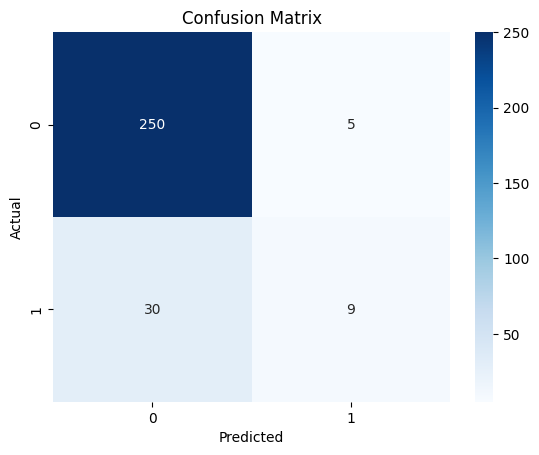

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       255
           1       0.64      0.23      0.34        39

    accuracy                           0.88       294
   macro avg       0.77      0.61      0.64       294
weighted avg       0.86      0.88      0.86       294



In [22]:


# Initialize and train the CatBoostClassifier
model = CatBoostClassifier(iterations=1000,  # Adjust as needed
                           learning_rate=0.1,  # Adjust as needed
                           depth=6,  # Adjust as needed
                           loss_function='Logloss',
                           eval_metric='AUC',
                           random_seed=42,
                           verbose=100) # Adjust verbosity as needed


model.fit(X_train, y_train, eval_set=(X_test, y_test))
joblib.dump(model, 'catboost_model.joblib')

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_test, y_pred))

In [28]:
if 'Attrition' in columns_used_for_label_encoder:  # Check if 'y' is in the list
    columns_used_for_label_encoder.remove('Attrition')

In [31]:
# Sample new data record (replace with your actual data)
new_data = pd.DataFrame({
    'Age': [35],
    'BusinessTravel': ['Travel_Rarely'],
    'DailyRate': [1102],
    'Department': ['Research & Development'],
    'DistanceFromHome': [10],
    'Education': [2],
    'EducationField': ['Medical'],
    'EmployeeCount': [1],
    'EmployeeNumber': [100],
    'EnvironmentSatisfaction': [3],
    'Gender': ['Male'],
    'HourlyRate': [50],
    'JobInvolvement': [3],
    'JobLevel': [2],
    'JobRole': ['Laboratory Technician'],
    'JobSatisfaction': [3],
    'MaritalStatus': ['Single'],
    'MonthlyIncome': [5000],
    'MonthlyRate': [20000],
    'NumCompaniesWorked': [2],
    'Over18': ['Y'],
    'OverTime': ['No'],
    'PercentSalaryHike': [15],
    'PerformanceRating': [3],
    'RelationshipSatisfaction': [3],
    'StandardHours': [80],
    'StockOptionLevel': [0],
    'TotalWorkingYears': [10],
    'TrainingTimesLastYear': [2],
    'WorkLifeBalance': [3],
    'YearsAtCompany': [5],
    'YearsInCurrentRole': [4],
    'YearsSinceLastPromotion': [1],
    'YearsWithCurrManager': [3]
})


def preprocess_new_data(new_record):
    # Convert the new record to a DataFrame
    new_record_df = new_record.copy()

    # Preprocessing steps (replicate the training preprocessing)
    for col in columns_used_for_label_encoder:
        le = joblib.load(f'label_encoder_{col}.joblib')
        new_record_df[col] = le.transform(new_record_df[col])

    # Perform one-hot encoding for all columns at once outside the loop
    new_record_df = pd.get_dummies(new_record_df, columns=columns_used_for_One_hot_encode)

    # Ensure all columns from training are present
    for c in X.columns: # Use X.columns for training data columns
        if c not in new_record_df.columns:
            new_record_df[c] = 0

    # Align columns with the training data
    new_record_df = new_record_df[X.columns]  # Use X.columns for training data columns



    return new_record_df



In [32]:
# prompt: load model and predict for new_data

# Load the trained model
loaded_model = joblib.load('catboost_model.joblib')

# Preprocess the new data
new_data_processed = preprocess_new_data(new_data)

# Make predictions on the new data
new_predictions = loaded_model.predict(new_data_processed)

print("Predictions for new data:", new_predictions)

Predictions for new data: [0]
